In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import re
import h5py

from functools import reduce
from ttt.utils import listfiles
from mlr.database.utils import read_metadata, write_metadata
from matplotlib import cm

In [2]:
def read_training_history(path):
    history_file = h5py.File(path,'r')
    history_dict = {x:np.array(y) for x, y in history_file.items()} 
    history_file.close()
    return history_dict

In [3]:
root_dir_base = pathlib.Path("/media/files/segmentation_networks/")
root_dirs = [root_dir_base.joinpath("baseline_small_datasets_HQ_redux_1_6_2022"),
            root_dir_base.joinpath("small_NP_networks_redux_1_6_2022"),
            root_dir_base.joinpath("substrate_networks_redux_1_7_2022"),
            root_dir_base.joinpath("super_network_1_25_2022"),
            root_dir_base.joinpath("transfer_learning_all_with_callbacks_2_2_2022")
            ]

root_dirs = [folder.joinpath("trained_models") for folder in root_dirs]
model_folders = [[x for x in listfiles(r) if x.is_dir()] for r in root_dirs]
model_folders = reduce(lambda x,y: x+y, model_folders)

In [4]:
## load all the metadata from the networks
metadata_list = []
for folder in model_folders:
    model_metadata = read_metadata(folder.joinpath("metadata.json"))    
    model_id = re.search("[0-9]+_[0-9]+", str(folder).rsplit("/")[-1])[0]
    model_metadata["ID"] = model_id
    if "transfer" in str(folder):
        tl = True
        history_path = "sm_unet_transferLearnWeights_" + model_metadata["backbone"]+"_history.h5"
        history_dict = read_training_history(folder.joinpath(history_path))
        model_metadata.update(history_dict)
        model_metadata["best_val_f1"] = history_dict["val_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["best_CdSe_f1"] = history_dict["CdSe_f1-score"][np.argmin(history_dict["CdSe_loss"])]
        model_metadata["best_Kath_f1"] = history_dict["Kath_f1-score"][np.argmin(history_dict["Kath_loss"])]
        model_metadata["CdSe_f1_at_val_peak"] = history_dict["CdSe_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["Kath_f1_at_val_peak"] = history_dict["Kath_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["series"] = "transfer"
    else:
        tl = False
        model_metadata["series"] = str(folder).rsplit("/")[-3].split("_")[0]
    model_metadata["transfer_learned"] = tl
    model_metadata["folder"] = folder
    metadata_list.append(model_metadata)
        
df = pd.DataFrame(metadata_list)
df = pd.concat([df, pd.DataFrame(df['schedule'].to_list(), columns = ['schedule_rate', 'schedule_timing'])], axis=1)

In [5]:
def reduce_wrap(X):
    try:
        return reduce(lambda x,y: x+y, X)
    except:
        return np.NAN

def return_orig_series(o_ID):
    if o_ID in baseline_IDs:
        return "baseline"
    elif o_ID in small_IDs:
        return "small"
    elif o_ID in sub_IDs:
        return "substrate"
    elif o_ID in super_IDs:
        return "super"
    else:
        return None

def str_len(X):
    try:
        return str(len(X))
    except:
        return np.NAN

baseline_IDs = list(df[df["series"]=="baseline"]["ID"])
small_IDs = list(df[df["series"]=="small"]["ID"])
sub_IDs = list(df[df["series"]=="substrate"]["ID"])
super_IDs =  list(df[df["series"]=="super"]["ID"])

df["orig_series"] =  df["orig_model_ID"].apply(return_orig_series)
df["substrate_thicknesses_str"] = df["substrate_thicknesses"].apply(reduce_wrap)
df["substrate_thicknesses_N"] = df["substrate_thicknesses"].apply(str_len)

Text(0.5, 1.0, 'Kate CdSe--best')

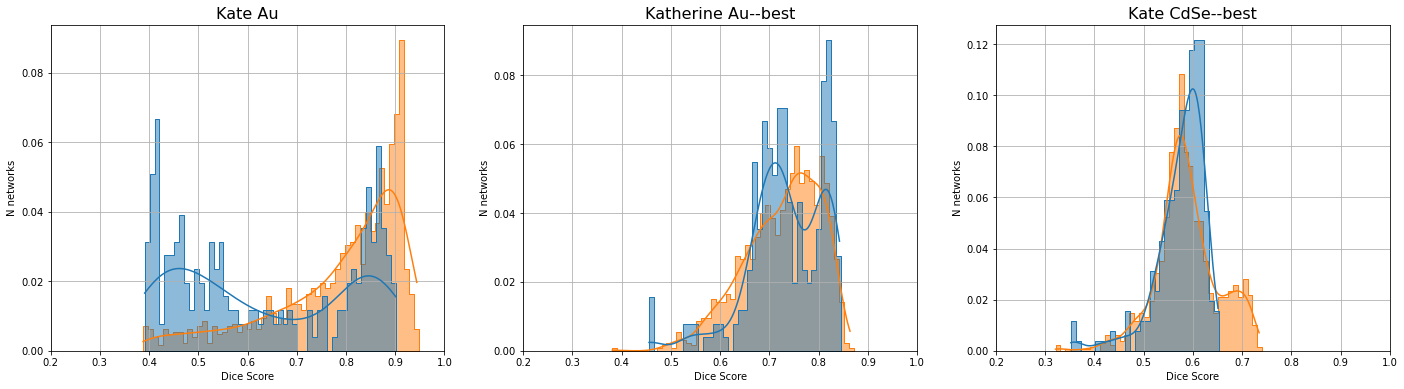

In [6]:
fig, axes = plt.subplots(1,3,figsize=(24,6))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"}
sns.histplot(ax=axes[0], data=df[df["transfer_learned"]==True], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
sns.histplot(ax=axes[0], data=df[df["transfer_learned"]==False], x="exp_f1-score", **style_args)

sns.histplot(ax=axes[1], data=df[df["transfer_learned"]==True], x="best_Kath_f1", color=cm.get_cmap("tab10")(1), **style_args)
sns.histplot(ax=axes[1], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", **style_args)

sns.histplot(ax=axes[2], data=df[df["transfer_learned"]==True], x="best_CdSe_f1", color=cm.get_cmap("tab10")(1), **style_args)
sns.histplot(ax=axes[2], data=df[df["transfer_learned"]==False], x="exp_f1-score_CdSe", **style_args)

axes[0].set_title("Kate Au performance")
axes[1].set_title("Katherine Au performance")
axes[2].set_title("Kate CdSe performance")

for ax in axes:
    ax.set_ylabel("N networks")
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0].set_title("Kate Au", fontsize=16)
axes[1].set_title("Katherine Au--best", fontsize=16)
axes[2].set_title("Kate CdSe--best", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe at Kate Au peak')

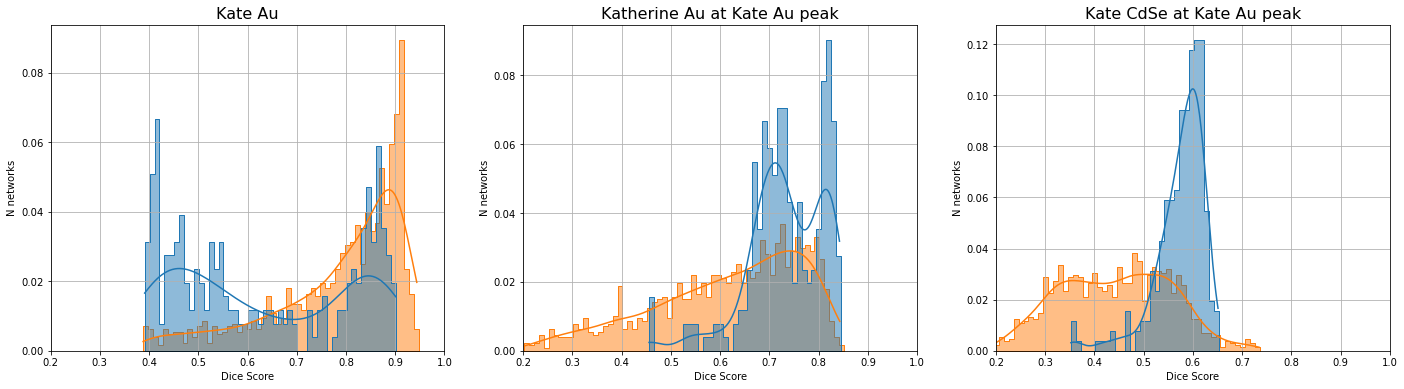

In [7]:
fig, axes = plt.subplots(1,3,figsize=(24,6))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"}
sns.histplot(ax=axes[0], data=df[df["transfer_learned"]==True], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
sns.histplot(ax=axes[0], data=df[df["transfer_learned"]==False], x="exp_f1-score", **style_args)

sns.histplot(ax=axes[1], data=df[df["transfer_learned"]==True], x="Kath_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)
sns.histplot(ax=axes[1], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", **style_args)

sns.histplot(ax=axes[2], data=df[df["transfer_learned"]==True], x="CdSe_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)
sns.histplot(ax=axes[2], data=df[df["transfer_learned"]==False], x="exp_f1-score_CdSe", **style_args)

axes[0].set_title("Kate Au performance")
axes[1].set_title("Katherine Au performance")
axes[2].set_title("Kate CdSe performance")

for ax in axes:
    ax.set_ylabel("N networks")
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0].set_title("Kate Au", fontsize=16)
axes[1].set_title("Katherine Au at Kate Au peak", fontsize=16)
axes[2].set_title("Kate CdSe at Kate Au peak", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe')

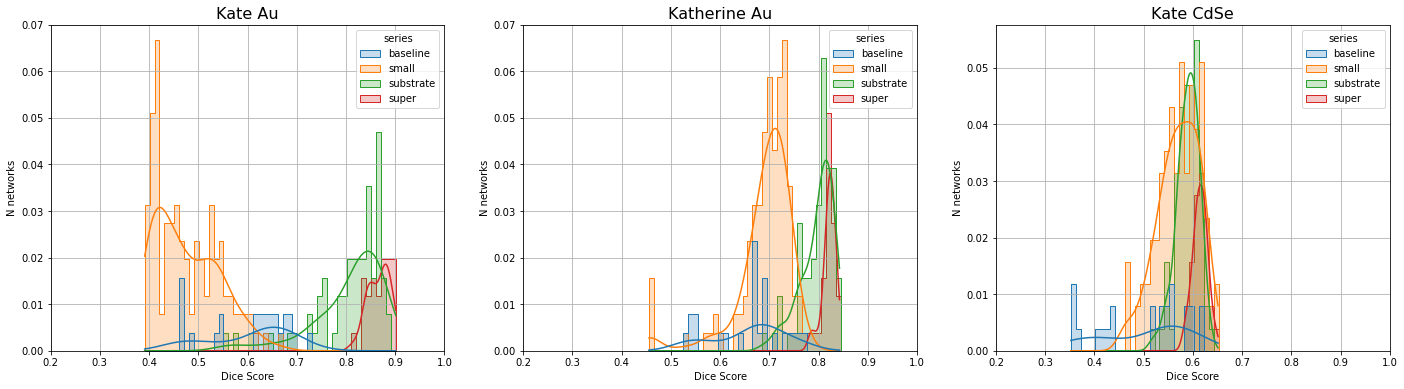

In [8]:
fig, axes = plt.subplots(1,3,figsize=(24,6))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }
sns.histplot(ax=axes[0], data=df[df["transfer_learned"]==False], x="exp_f1-score", hue="series",**style_args)
sns.histplot(ax=axes[1], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", hue="series",**style_args)
sns.histplot(ax=axes[2], data=df[df["transfer_learned"]==False], x="exp_f1-score_CdSe", hue="series",**style_args)


axes[0].set_title("Kate Au performance")
axes[1].set_title("Katherine Au performance")
axes[2].set_title("Kate CdSe performance")

for ax in axes:
    ax.set_ylabel("N networks")
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0].set_title("Kate Au", fontsize=16)
axes[1].set_title("Katherine Au", fontsize=16)
axes[2].set_title("Kate CdSe", fontsize=16)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


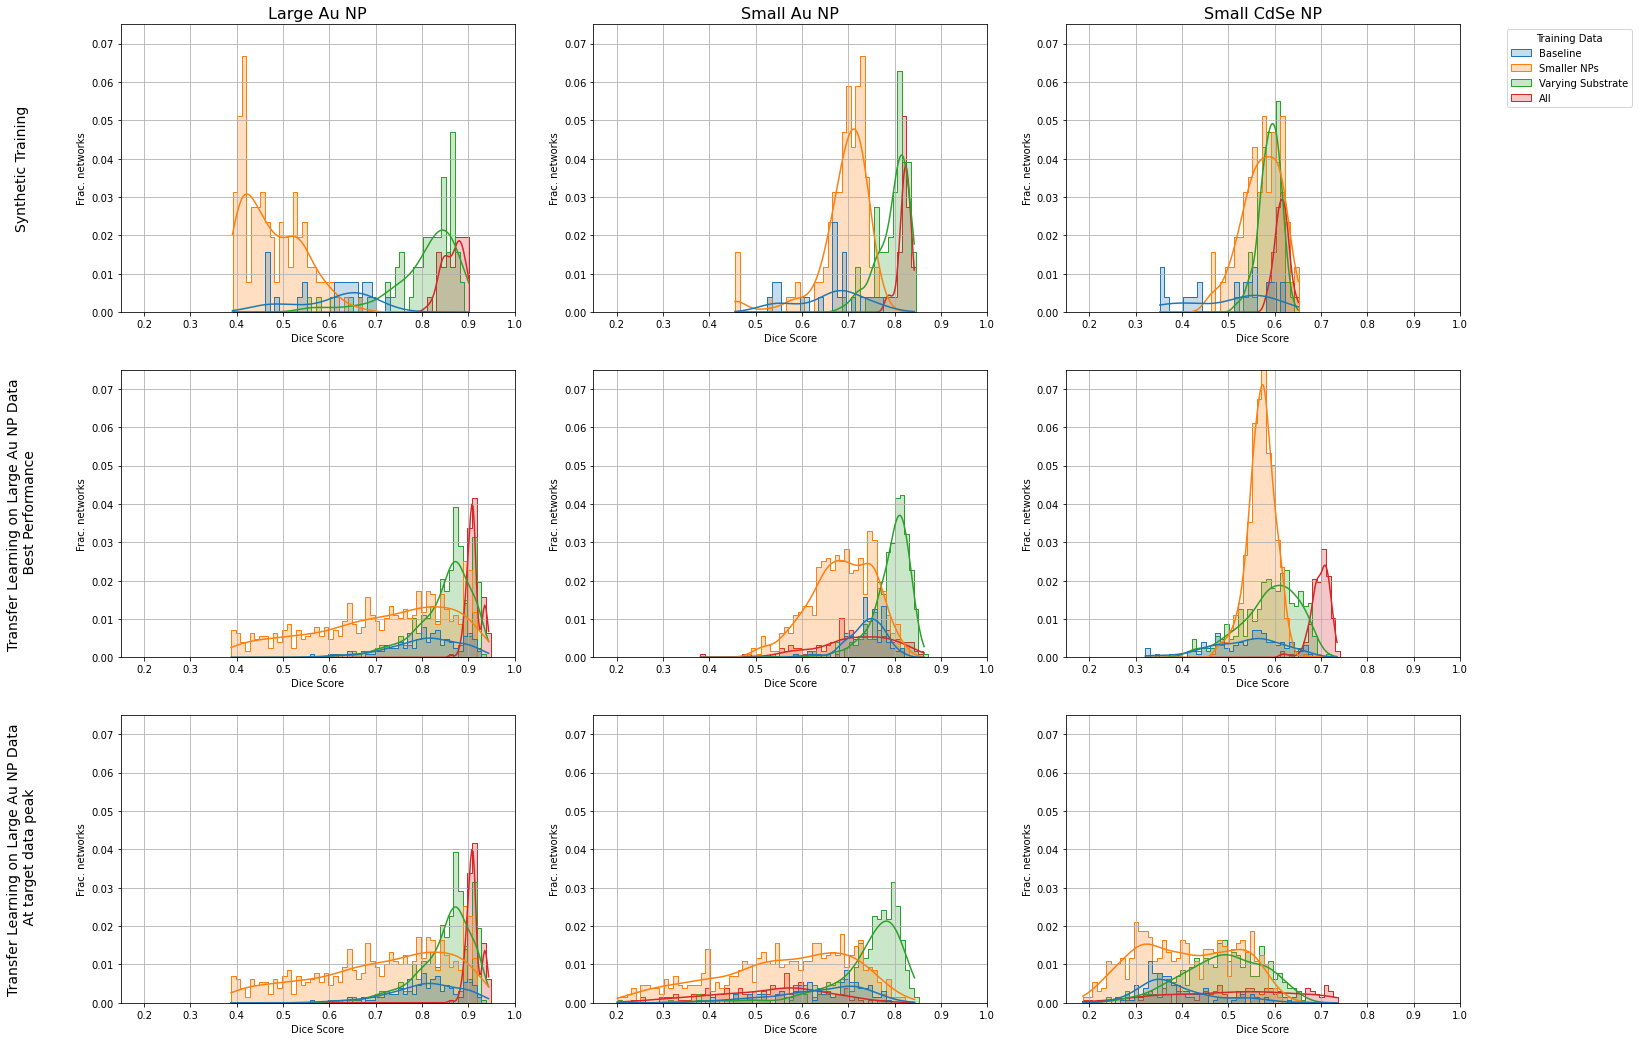

In [9]:
fig, axes = plt.subplots(3,3,figsize=(24,18))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step",
              "hue_order":["baseline", "small", "substrate", "super"],
              }
sns.histplot(ax=axes[0,0], data=df[df["transfer_learned"]==False], x="exp_f1-score", hue="series",**style_args)
sns.histplot(ax=axes[0,1], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", hue="series",**style_args)
g = sns.histplot(ax=axes[0,2], data=df[df["transfer_learned"]==False], x="exp_f1-score_CdSe", hue="series",**style_args)

sns.histplot(ax=axes[1,0], data=df[df["transfer_learned"]==True], x="best_val_f1", hue="orig_series",**style_args)
sns.histplot(ax=axes[1,1], data=df[df["transfer_learned"]==True], x="best_Kath_f1", hue="orig_series",**style_args)
sns.histplot(ax=axes[1,2], data=df[df["transfer_learned"]==True], x="best_CdSe_f1", hue="orig_series",**style_args)

sns.histplot(ax=axes[2,0], data=df[df["transfer_learned"]==True], x="best_val_f1", hue="orig_series",**style_args)
sns.histplot(ax=axes[2,1], data=df[df["transfer_learned"]==True], x="Kath_f1_at_val_peak", hue="orig_series",**style_args)
sns.histplot(ax=axes[2,2], data=df[df["transfer_learned"]==True], x="CdSe_f1_at_val_peak", hue="orig_series",**style_args)

g.legend_.set_bbox_to_anchor([1.45, 1,0,0], transform = axes[0,2].transAxes)
g.legend_.set_title("Training Data")
new_labels = ['Baseline', 'Smaller NPs', 'Varying Substrate',  'All']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

axes[0,0].legend().set_visible(False)
axes[0,1].legend().set_visible(False)

axes[1,0].legend().set_visible(False)
axes[1,1].legend().set_visible(False)
axes[1,2].legend().set_visible(False)

axes[2,0].legend().set_visible(False)
axes[2,1].legend().set_visible(False)
axes[2,2].legend().set_visible(False)
            
for ax in axes.ravel():
    ax.set_ylabel("Frac. networks")
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.15, 1])
    ax.set_ylim([0, 0.075])

axes[0, 0].set_title("Large Au NP", fontsize=16)
axes[0, 1].set_title("Small Au NP", fontsize=16)
axes[0, 2].set_title("Small CdSe NP", fontsize=16)

axes[0,0].text(-0.25, 0.5, "Synthetic Training", fontsize=14, rotation=90, transform=axes[0,0].transAxes, ha="center", va="center")
axes[1,0].text(-0.25, 0.5, "Transfer Learning on Large Au NP Data\n Best Performance", fontsize=14, rotation=90, transform=axes[1,0].transAxes, ha="center", va="center")
axes[2,0].text(-0.25, 0.5, "Transfer Learning on Large Au NP Data\n At target data peak", fontsize=14, rotation=90, transform=axes[2,0].transAxes, ha="center", va="center")

plt.savefig("transfer_learning_performance_summary.png", dpi=300)

Text(0.5, 1.0, 'Kate CdSe')

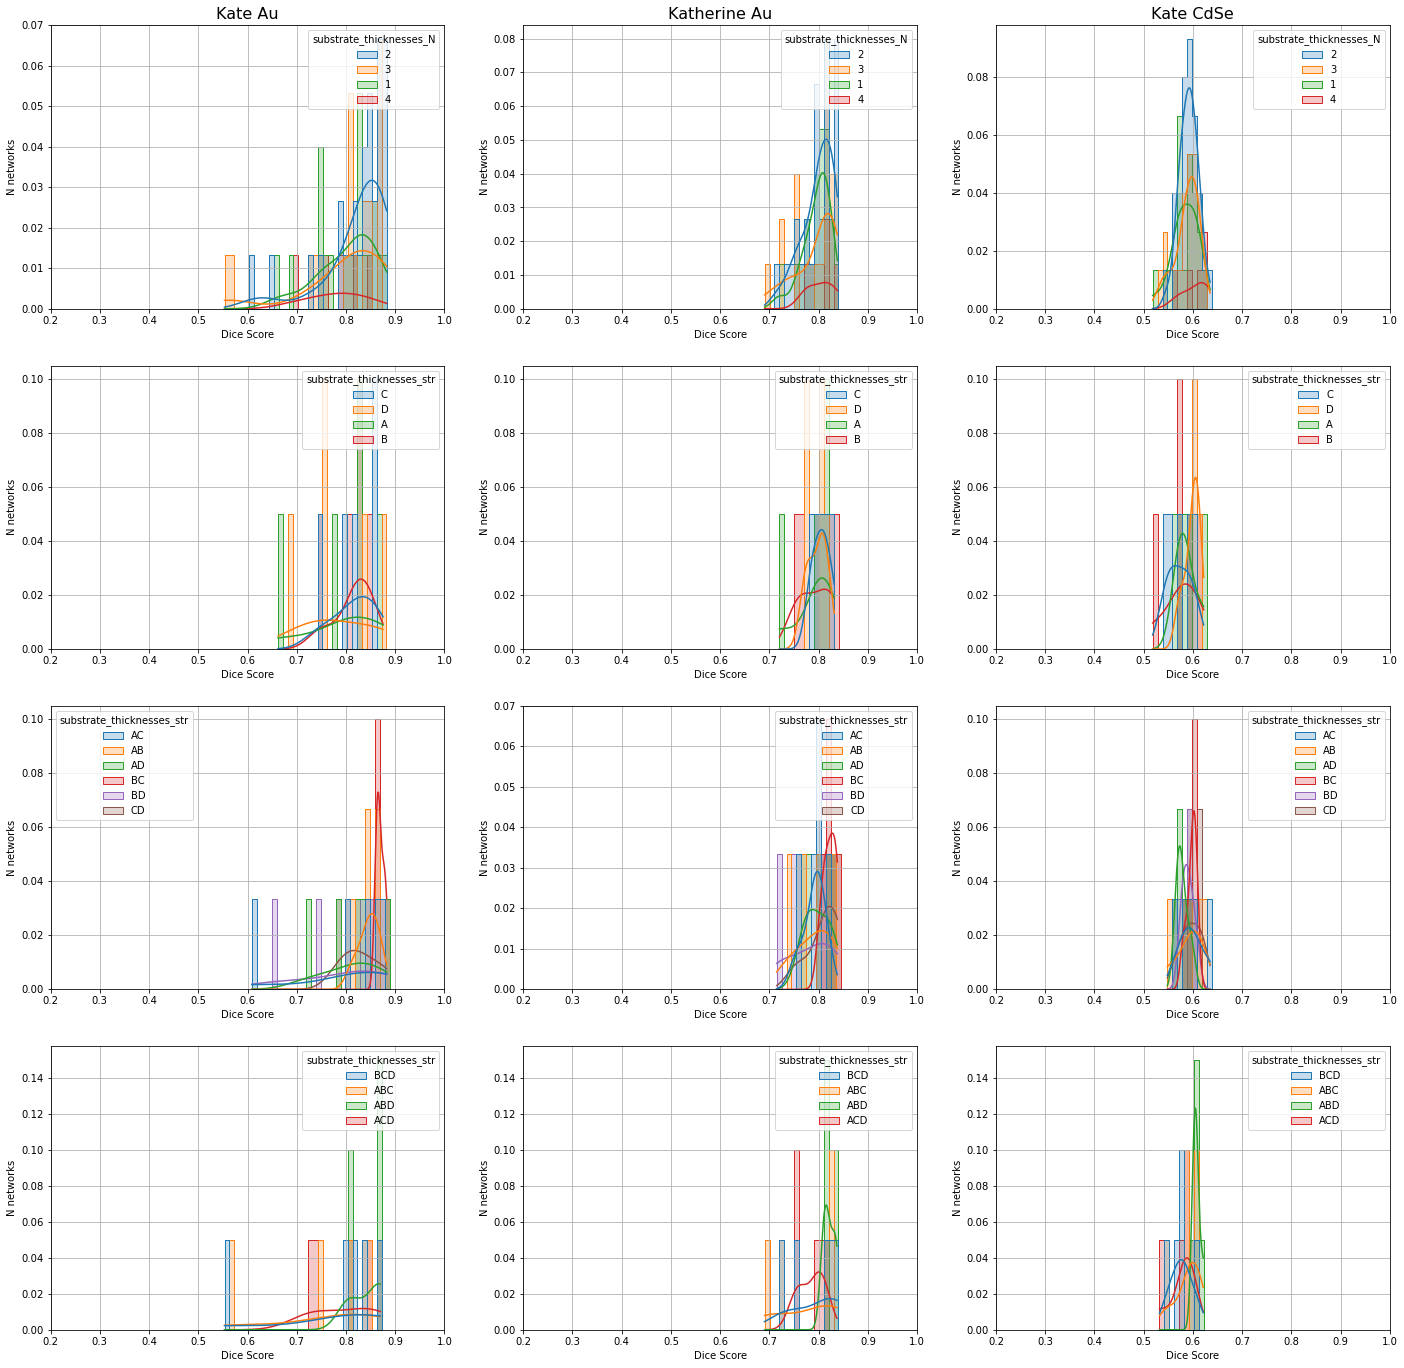

In [10]:
fig, axes = plt.subplots(4,3,figsize=(24,24))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }
r_df = df[df["series"]=="substrate"]
sns.histplot(ax=axes[0, 0], data=r_df, x="exp_f1-score", hue="substrate_thicknesses_N",**style_args)
sns.histplot(ax=axes[0, 1], data=r_df, x="exp_f1-score_katherine", hue="substrate_thicknesses_N",**style_args)
sns.histplot(ax=axes[0, 2], data=r_df, x="exp_f1-score_CdSe", hue="substrate_thicknesses_N",**style_args)

r_df1 = r_df[r_df["substrate_thicknesses_N"]==str(1)]
r_df2 = r_df[r_df["substrate_thicknesses_N"]==str(2)]
r_df3 = r_df[r_df["substrate_thicknesses_N"]==str(3)]
sns.histplot(ax=axes[1, 0], data=r_df1, x="exp_f1-score", hue="substrate_thicknesses_str",**style_args)
sns.histplot(ax=axes[1, 1], data=r_df1, x="exp_f1-score_katherine", hue="substrate_thicknesses_str",**style_args)
sns.histplot(ax=axes[1, 2], data=r_df1, x="exp_f1-score_CdSe", hue="substrate_thicknesses_str",**style_args)

sns.histplot(ax=axes[2, 0], data=r_df2, x="exp_f1-score", hue="substrate_thicknesses_str",**style_args)
sns.histplot(ax=axes[2, 1], data=r_df2, x="exp_f1-score_katherine", hue="substrate_thicknesses_str",**style_args)
sns.histplot(ax=axes[2, 2], data=r_df2, x="exp_f1-score_CdSe", hue="substrate_thicknesses_str",**style_args)

sns.histplot(ax=axes[3, 0], data=r_df3, x="exp_f1-score", hue="substrate_thicknesses_str",**style_args)
sns.histplot(ax=axes[3, 1], data=r_df3, x="exp_f1-score_katherine", hue="substrate_thicknesses_str",**style_args)
sns.histplot(ax=axes[3, 2], data=r_df3, x="exp_f1-score_CdSe", hue="substrate_thicknesses_str",**style_args)


for ax in axes.ravel():
    ax.set_ylabel("N networks")
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au", fontsize=16)
axes[0,2].set_title("Kate CdSe", fontsize=16)

In [11]:
scatter_dicts = []

# each dict needs: series, x_dice, y_dice, expt_val_split

for ids in [baseline_IDs, small_IDs, sub_IDs, super_IDs]:
    for i, row in df[df["orig_model_ID"].isin(ids)].iterrows():
        data_dict = {}
        data_dict["x_dice_kate"] = df[df["ID"]==row["orig_model_ID"]]["exp_f1-score"].values[0]
        data_dict["y_dice_kate"] = row["best_val_f1"]

        data_dict["x_dice_kath"] = df[df["ID"]==row["orig_model_ID"]]["exp_f1-score_katherine"].values[0]
        data_dict["y_dice_kath"] = row["best_Kath_f1"]
        data_dict["y_dice_kath_vp"] = row["Kath_f1_at_val_peak"]

        data_dict["x_dice_cdse"] = df[df["ID"]==row["orig_model_ID"]]["exp_f1-score_CdSe"].values[0]
        data_dict["y_dice_cdse"] = row["best_CdSe_f1"]
        data_dict["y_dice_cdse_vp"] = row["CdSe_f1_at_val_peak"]

        data_dict["split"] = row["expt_val_split"]
        data_dict["d_series"] = df[df["ID"]==row["orig_model_ID"]]["series"].values[0]
        scatter_dicts.append(data_dict)

scatter_df = pd.DataFrame(scatter_dicts)

Text(0.5, 1.0, 'Kate CdSe--best')

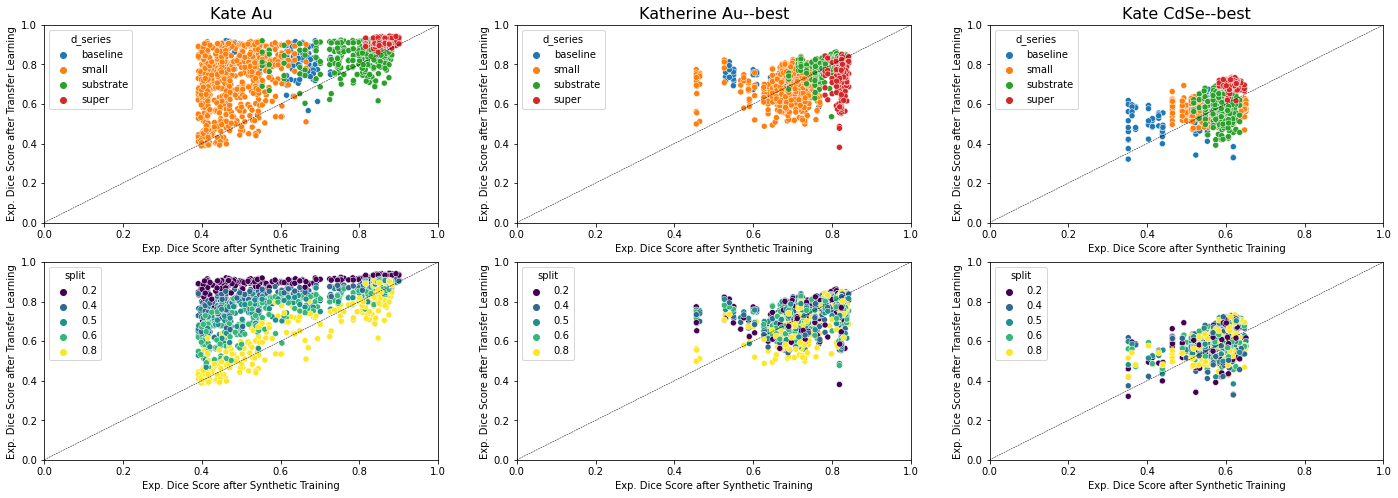

In [12]:
fig, axes = plt.subplots(2,3,figsize=(24,8))

for ax in axes.ravel():
    ax.set_xlabel("Exp. Dice Score after Synthetic Training")
    ax.set_ylabel("Exp. Dice Score after Transfer Learning")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot([0,1],[0,1], linestyle="--", linewidth=0.5,color="k")
    
sns.scatterplot(ax=axes[0,0], data=scatter_df, x="x_dice_kate", y='y_dice_kate', hue="d_series")
sns.scatterplot(ax=axes[1,0], data=scatter_df, x="x_dice_kate", y='y_dice_kate', hue="split", palette="viridis")

sns.scatterplot(ax=axes[0,1], data=scatter_df, x="x_dice_kath", y='y_dice_kath', hue="d_series")
sns.scatterplot(ax=axes[1,1], data=scatter_df, x="x_dice_kath", y='y_dice_kath', hue="split", palette="viridis")

sns.scatterplot(ax=axes[0,2], data=scatter_df, x="x_dice_cdse", y='y_dice_cdse', hue="d_series")
sns.scatterplot(ax=axes[1,2], data=scatter_df, x="x_dice_cdse", y='y_dice_cdse', hue="split", palette="viridis")

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au--best", fontsize=16)
axes[0,2].set_title("Kate CdSe--best", fontsize=16)


Text(0.5, 1.0, 'Kate CdSe at Kate Au Peak')

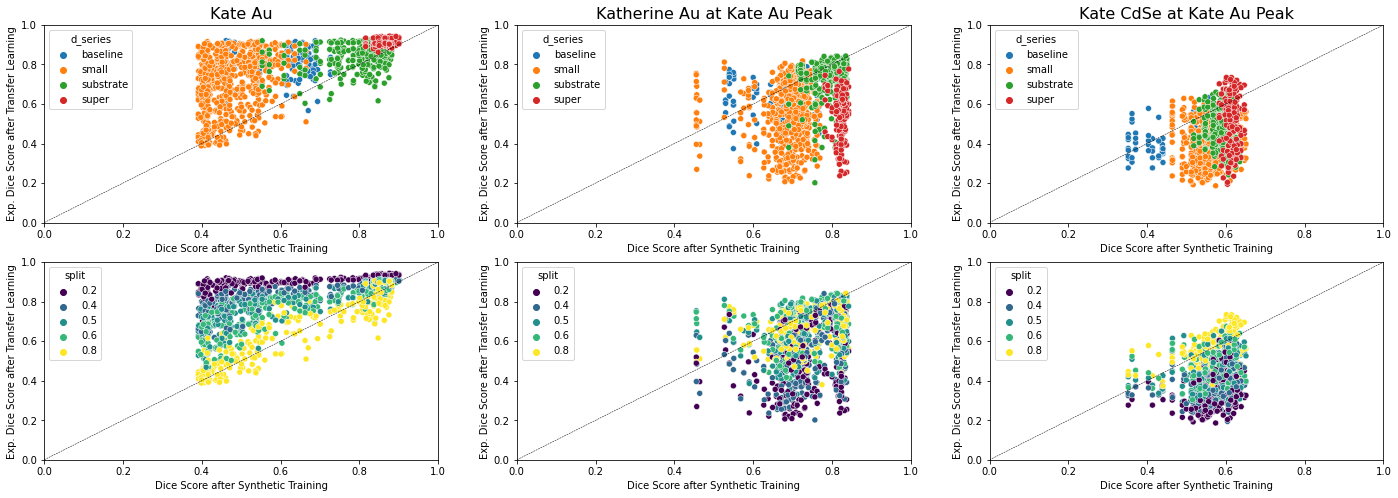

In [13]:
fig, axes = plt.subplots(2,3,figsize=(24,8))

for ax in axes.ravel():
    ax.set_xlabel("Dice Score after Synthetic Training")
    ax.set_ylabel("Exp. Dice Score after Transfer Learning")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot([0,1],[0,1], linestyle="--", linewidth=0.5,color="k")
    
sns.scatterplot(ax=axes[0,0], data=scatter_df, x="x_dice_kate", y='y_dice_kate', hue="d_series")
sns.scatterplot(ax=axes[1,0], data=scatter_df, x="x_dice_kate", y='y_dice_kate', hue="split", palette="viridis")

sns.scatterplot(ax=axes[0,1], data=scatter_df, x="x_dice_kath", y='y_dice_kath_vp', hue="d_series")
sns.scatterplot(ax=axes[1,1], data=scatter_df, x="x_dice_kath", y='y_dice_kath_vp', hue="split", palette="viridis")

sns.scatterplot(ax=axes[0,2], data=scatter_df, x="x_dice_cdse", y='y_dice_cdse_vp', hue="d_series")
sns.scatterplot(ax=axes[1,2], data=scatter_df, x="x_dice_cdse", y='y_dice_cdse_vp', hue="split", palette="viridis")

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au at Kate Au Peak", fontsize=16)
axes[0,2].set_title("Kate CdSe at Kate Au Peak", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe')

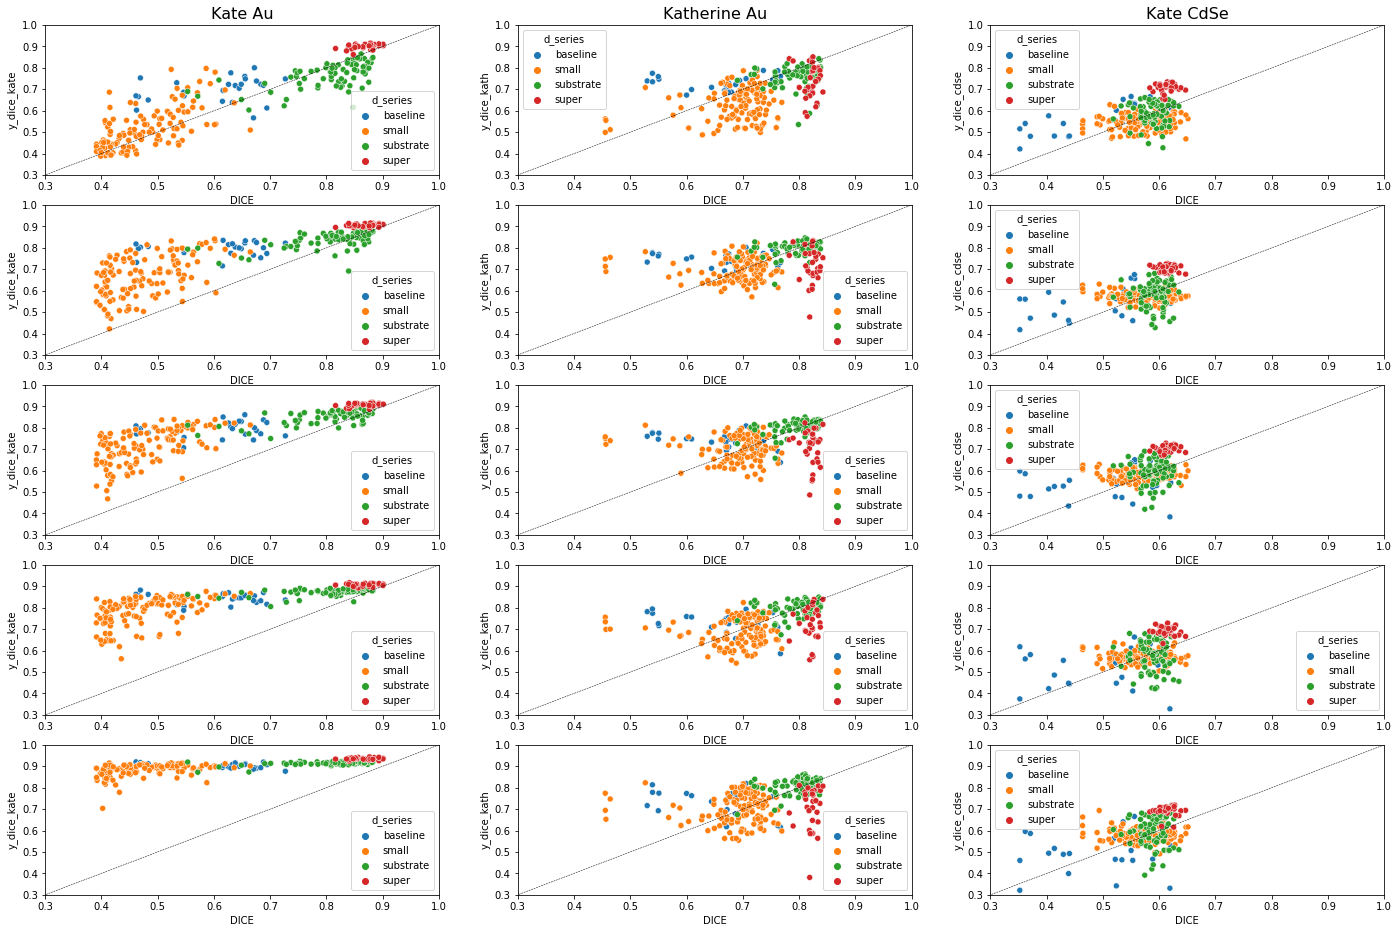

In [14]:
fig, axes = plt.subplots(5,3,figsize=(24,16))

splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i, axe in enumerate(axes):
    for ax in axe:
        ax.set_xlabel("DICE")
        ax.set_xlim([0.3, 1])
        ax.set_ylim([0.3,1])
        ax.plot([0,1],[0,1], linestyle="--", linewidth=0.5,color="k")
        ax.set_ylabel("")

    sns.scatterplot(ax=axe[0], data=scatter_df[scatter_df["split"]==splits[i]], x="x_dice_kate", y='y_dice_kate', hue="d_series")
    sns.scatterplot(ax=axe[1], data=scatter_df[scatter_df["split"]==splits[i]], x="x_dice_kath", y='y_dice_kath', hue="d_series")
    sns.scatterplot(ax=axe[2], data=scatter_df[scatter_df["split"]==splits[i]], x="x_dice_cdse", y='y_dice_cdse', hue="d_series")


axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au", fontsize=16)
axes[0,2].set_title("Kate CdSe", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe--best')

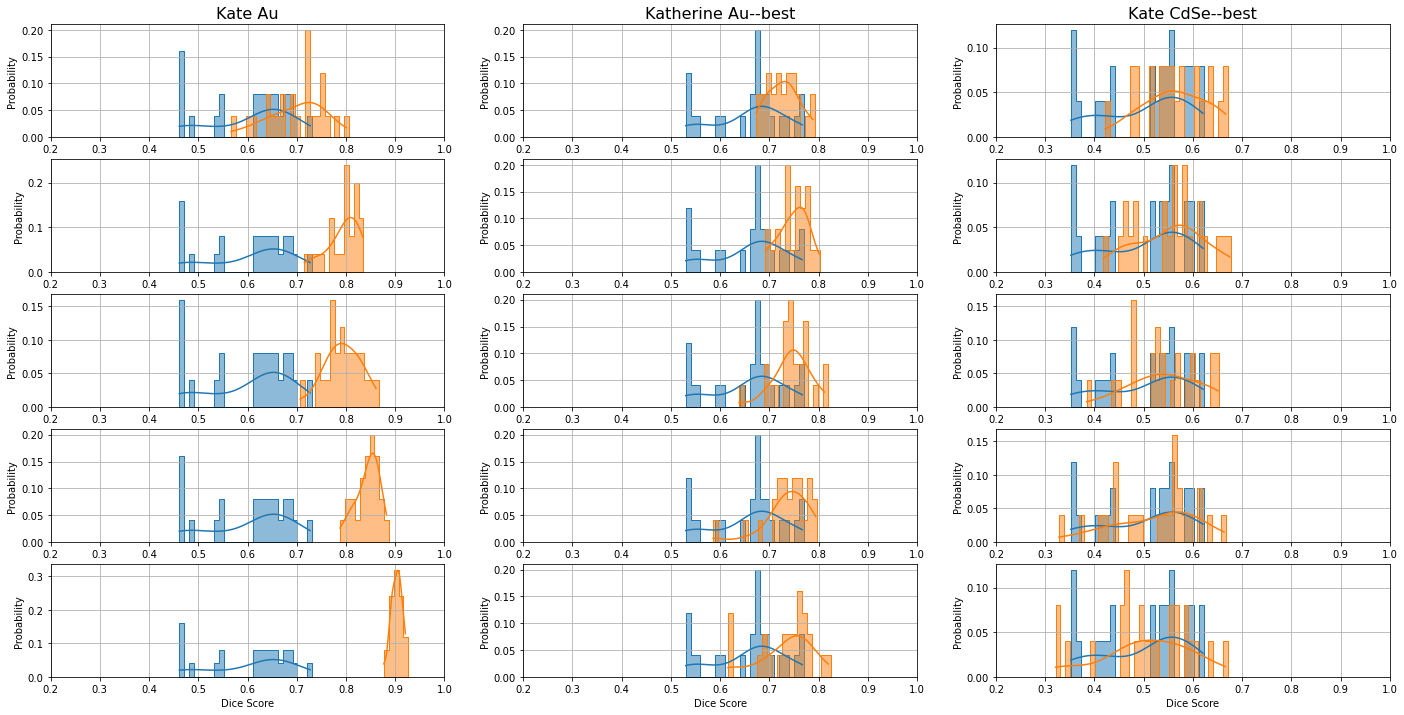

In [15]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="baseline"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="baseline"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_Kath_f1", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="baseline"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_CdSe_f1", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au--best", fontsize=16)
axes[0,2].set_title("Kate CdSe--best", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe at Kate Au peak')

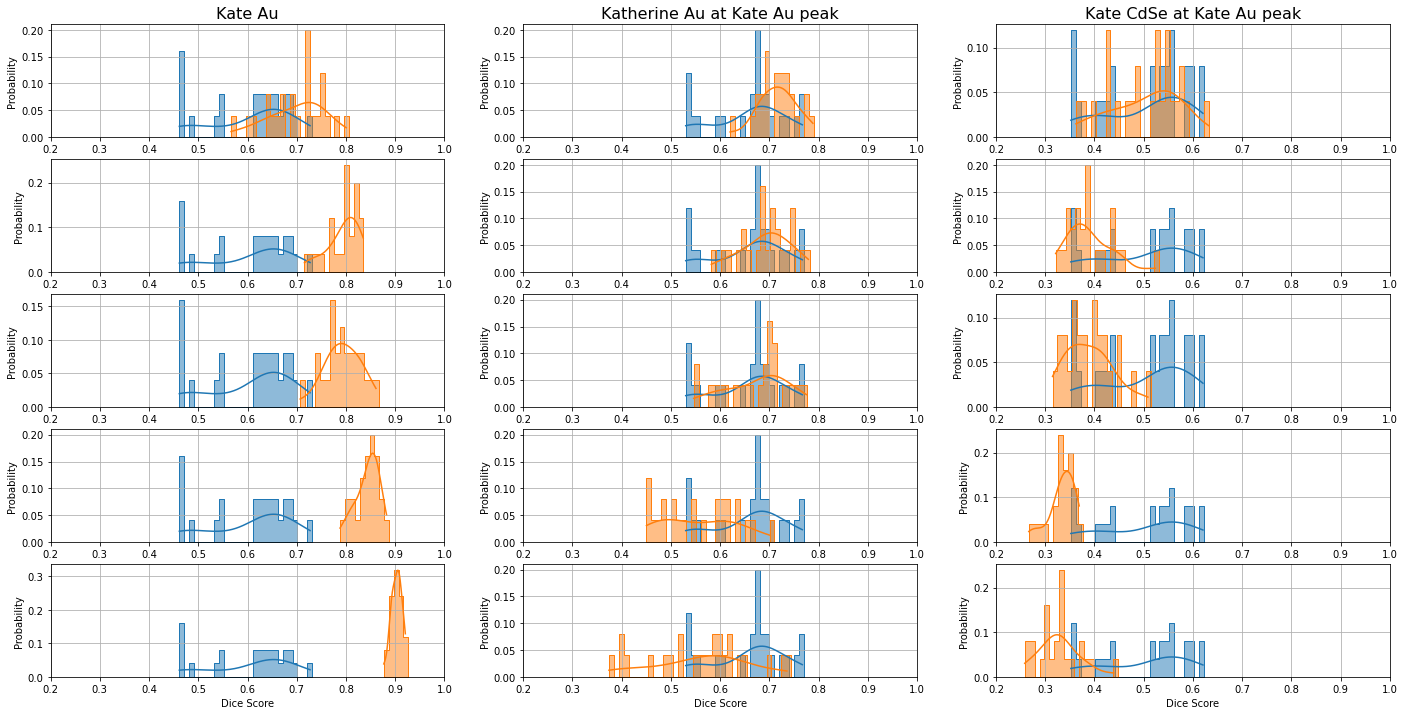

In [16]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="baseline"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="baseline"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="Kath_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="baseline"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="CdSe_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au at Kate Au peak", fontsize=16)
axes[0,2].set_title("Kate CdSe at Kate Au peak", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe--best')

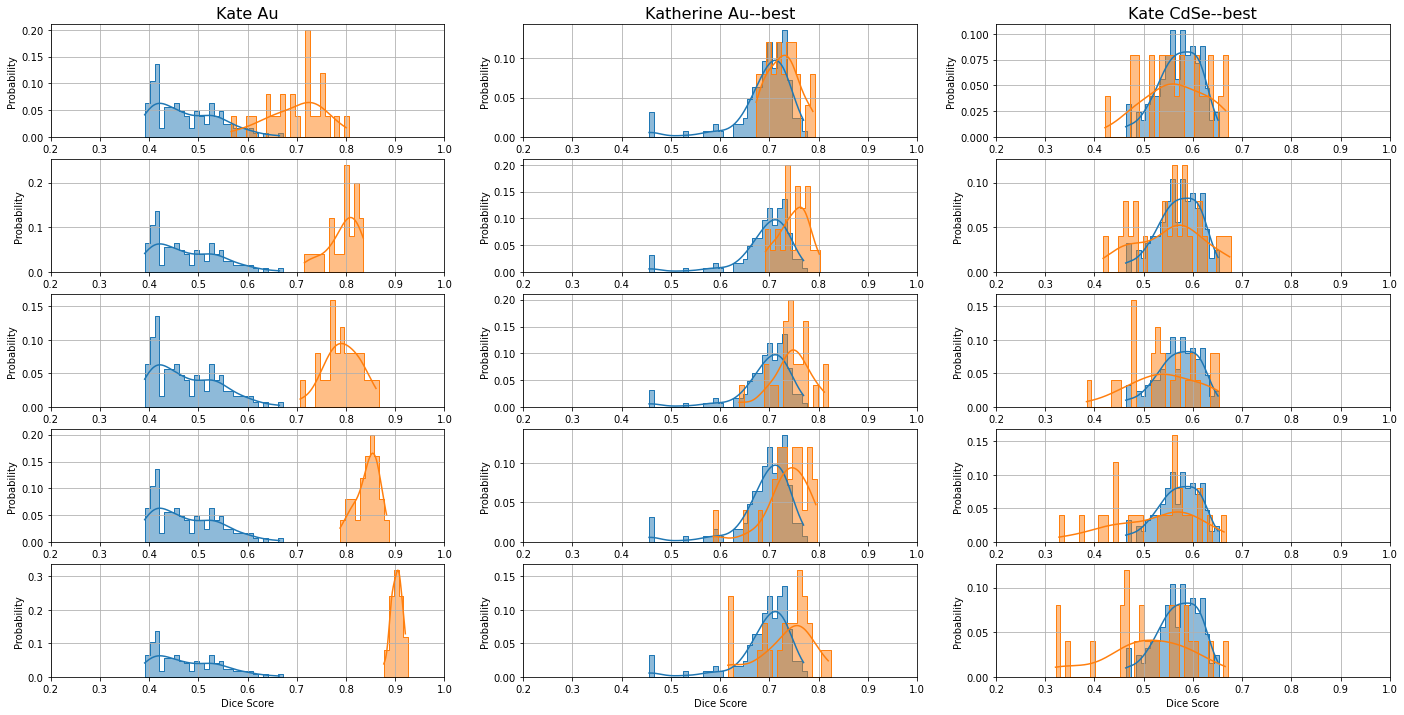

In [17]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="small"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="small"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_Kath_f1", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="small"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_CdSe_f1", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au--best", fontsize=16)
axes[0,2].set_title("Kate CdSe--best", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe at Kate Au peak')

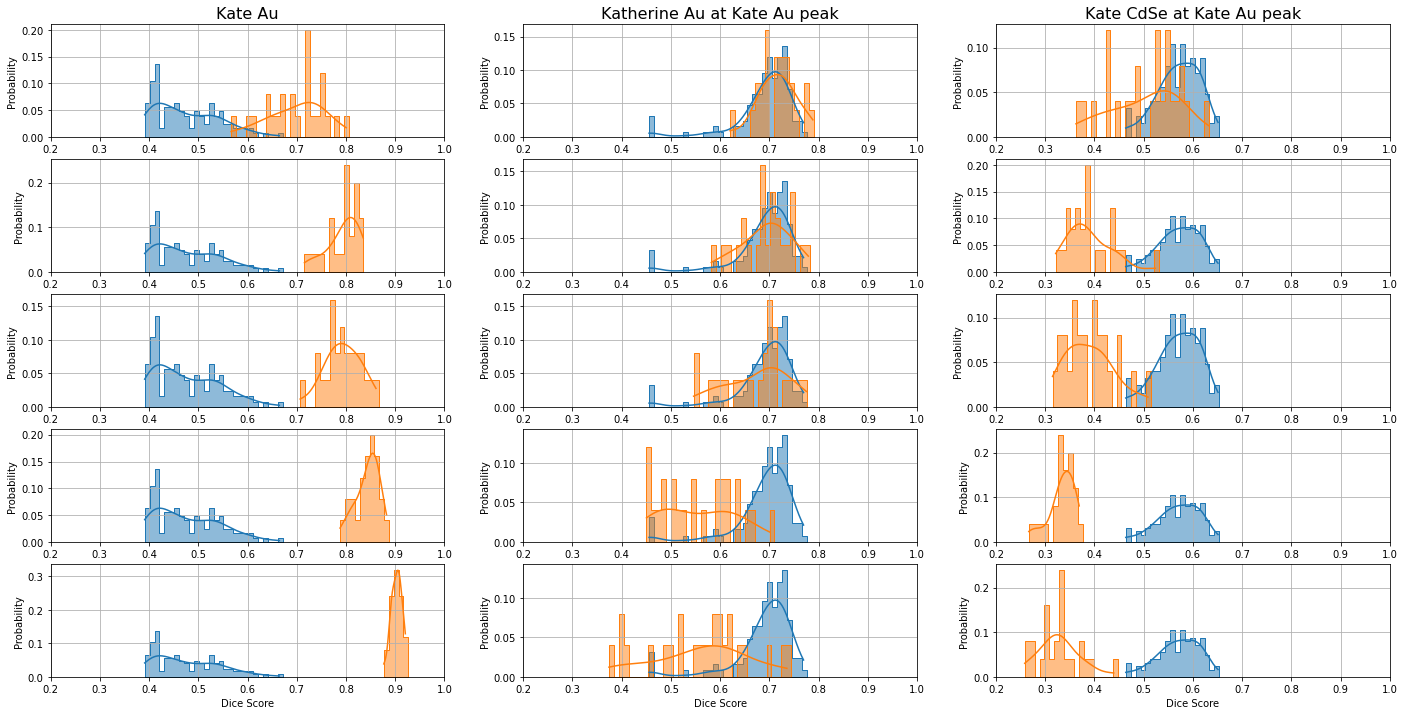

In [18]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="small"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="small"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="Kath_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="small"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="CdSe_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au at Kate Au peak", fontsize=16)
axes[0,2].set_title("Kate CdSe at Kate Au peak", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe--best')

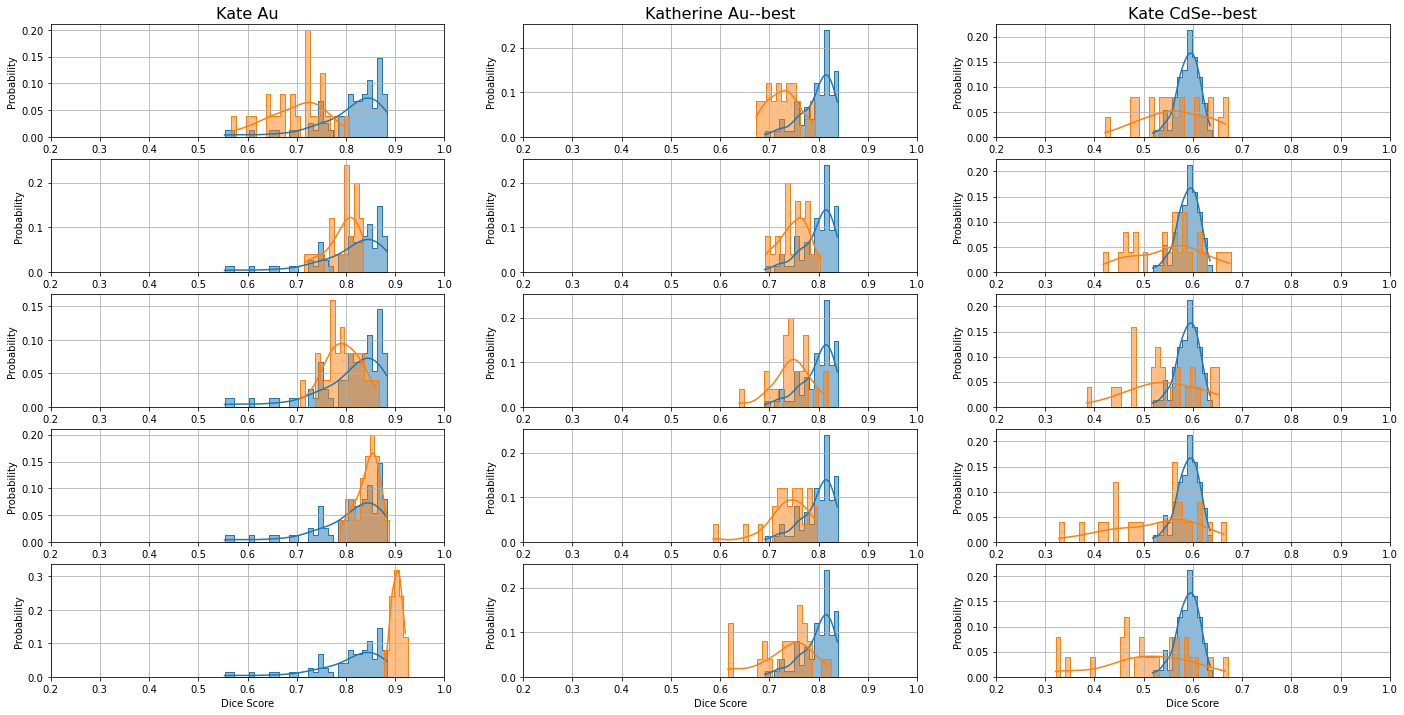

In [19]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="substrate"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="substrate"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_Kath_f1", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="substrate"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_CdSe_f1", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au--best", fontsize=16)
axes[0,2].set_title("Kate CdSe--best", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe at Kate Au peak')

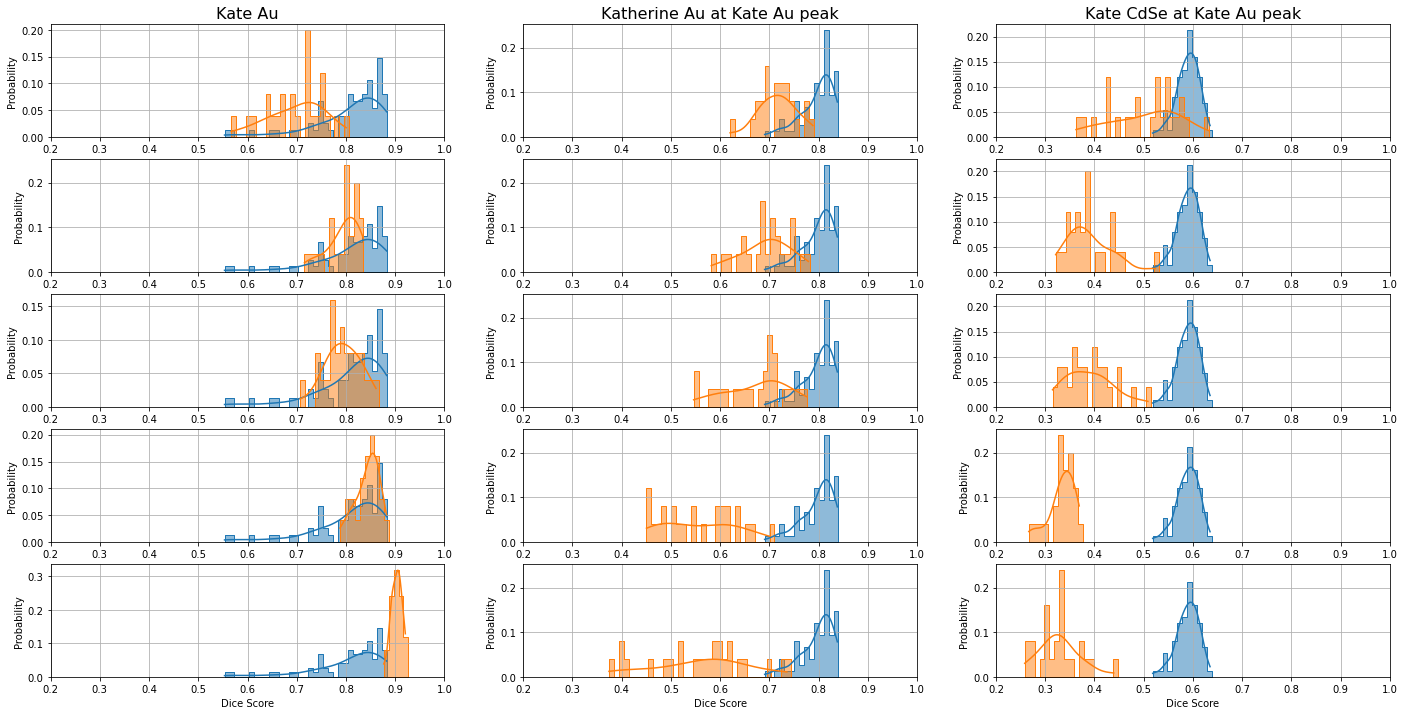

In [20]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="substrate"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="substrate"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="Kath_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="substrate"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="CdSe_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au at Kate Au peak", fontsize=16)
axes[0,2].set_title("Kate CdSe at Kate Au peak", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe--best')

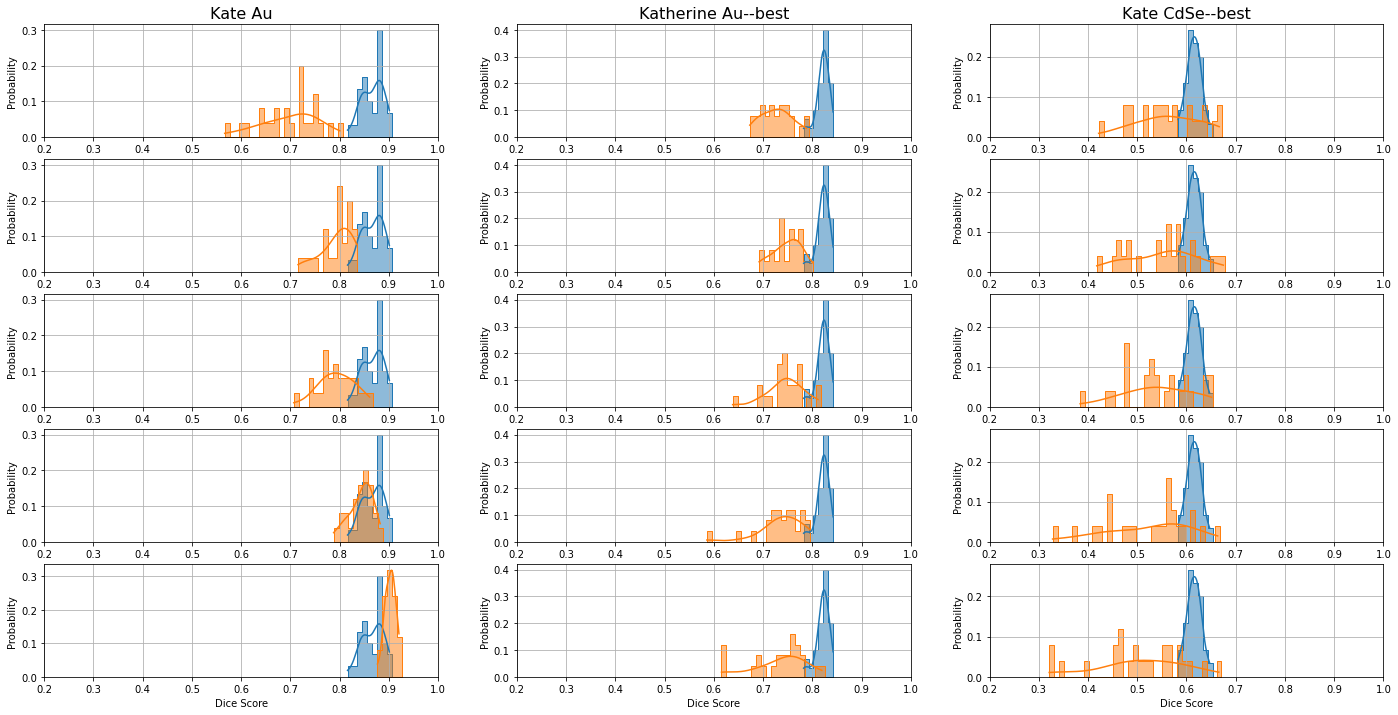

In [21]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="super"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="super"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_Kath_f1", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="super"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_CdSe_f1", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au--best", fontsize=16)
axes[0,2].set_title("Kate CdSe--best", fontsize=16)

Text(0.5, 1.0, 'Kate CdSe at Kate Au peak')

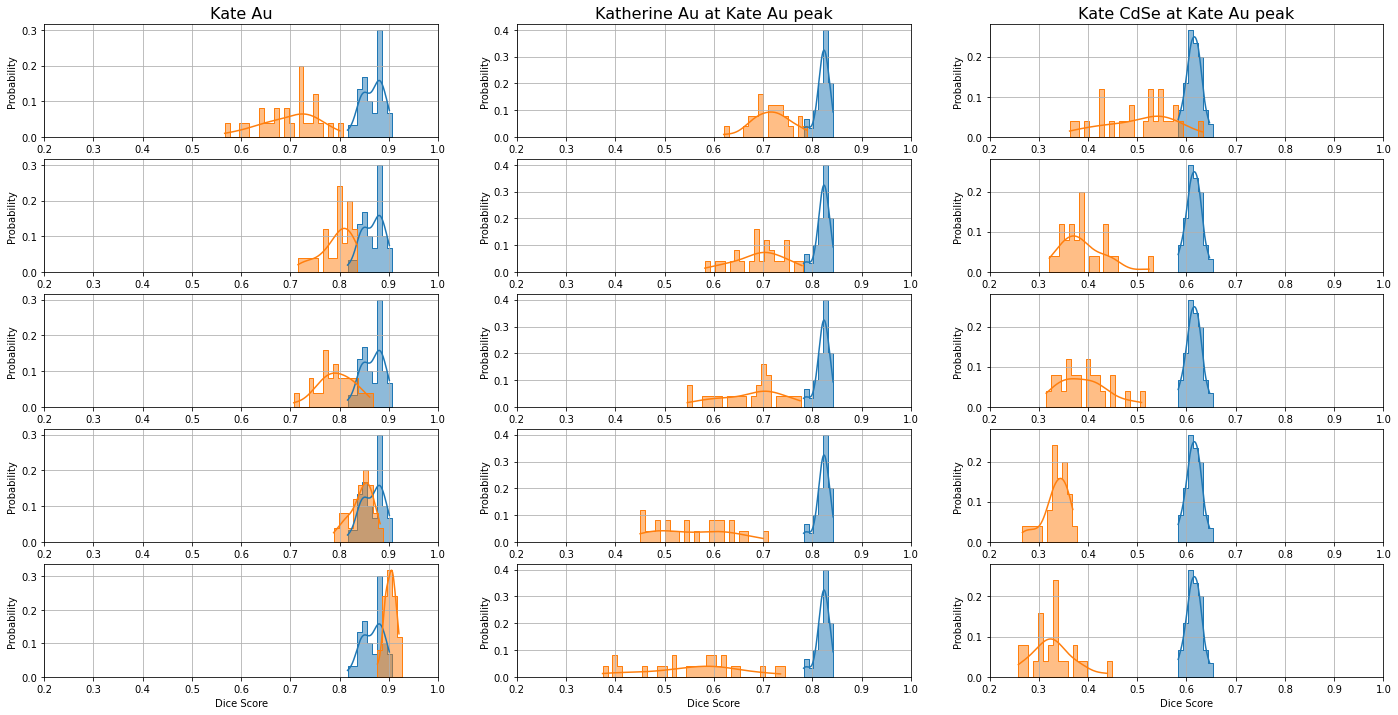

In [22]:
fig, axes = plt.subplots(5,3, figsize=(24,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(ax=axes[i,0], data=df[df["series"]=="super"], x="exp_f1-score", **style_args)
    sns.histplot(ax=axes[i,0], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
    
    sns.histplot(ax=axes[i,1], data=df[df["series"]=="super"], x="exp_f1-score_katherine", **style_args)
    sns.histplot(ax=axes[i,1], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="Kath_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

    sns.histplot(ax=axes[i,2], data=df[df["series"]=="super"], x="exp_f1-score_CdSe", **style_args)
    sns.histplot(ax=axes[i,2], data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="CdSe_f1_at_val_peak", color=cm.get_cmap("tab10")(1), **style_args)

for ax in axes.ravel():
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Kate Au", fontsize=16)
axes[0,1].set_title("Katherine Au at Kate Au peak", fontsize=16)
axes[0,2].set_title("Kate CdSe at Kate Au peak", fontsize=16)

## M&M abstract figures

For Mary

No handles with labels found to put in legend.


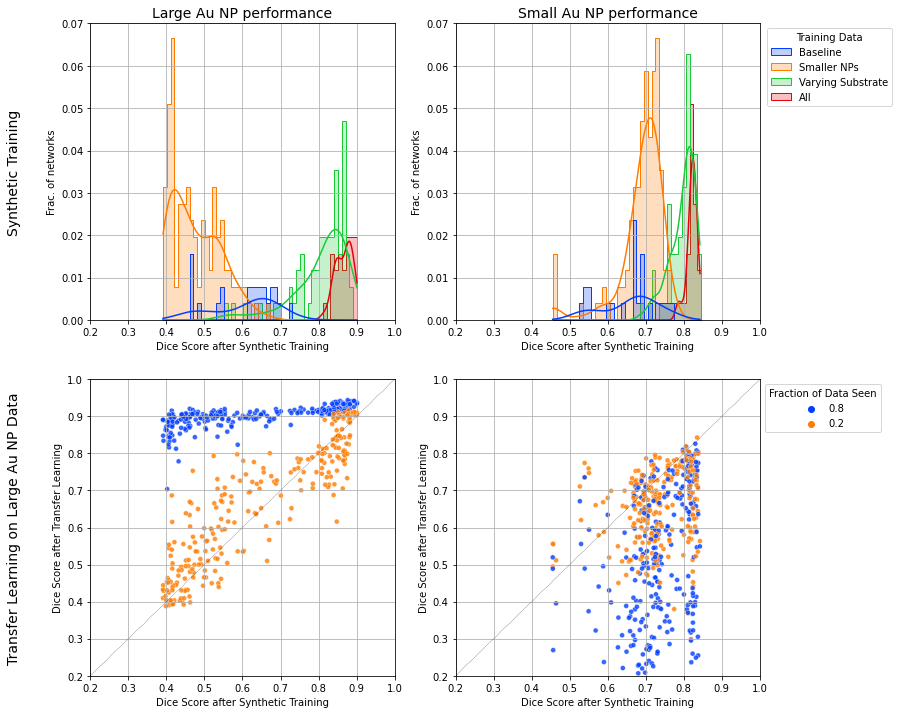

In [23]:
fig, axes = plt.subplots(2,2,figsize=(12,12), facecolor="w")

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step",
              "palette":"bright"
              }
sns.histplot(ax=axes[0,0], data=df[df["transfer_learned"]==False], x="exp_f1-score", hue="series",**style_args)
g = sns.histplot(ax=axes[0,1], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", hue="series",**style_args)

# g.legend_.set_bbox_to_anchor([0.45,1,0,0], transform = axes[0,1].transAxes)
g.legend_.set_bbox_to_anchor([1.45, 1,0,0], transform = axes[0,1].transAxes)
g.legend_.set_title("Training Data")
new_labels = ['Baseline', 'Smaller NPs', 'Varying Substrate',  'All']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

axes[0,0].legend().set_visible(False)
# g.legend_._set_loc('upper left')
# print(dir(g.legend_))
# axes[0,1].legend(title='Training Data', loc='upper left', labels=['All', 'Varying Substrate', 'Smaller NPs', 'Baseline'])

for ax in axes.ravel():
    ax.set_ylabel("Frac. of networks")
    ax.set_xlabel("Dice Score after Synthetic Training")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

axes[0,0].set_title("Large Au NP performance", fontsize=14)
axes[0,1].set_title("Small Au NP performance", fontsize=14)


#######################

r_scatter_df = scatter_df[(scatter_df["split"]==0.2) | (scatter_df["split"]==0.8)]
sns.scatterplot(ax=axes[1,0], data=r_scatter_df, x="x_dice_kate", y='y_dice_kate', hue="split", palette="bright", s=25, alpha=0.8)
g = sns.scatterplot(ax=axes[1,1], data=r_scatter_df, x="x_dice_kath", y='y_dice_kath_vp', hue="split", palette="bright", s=25, alpha=0.8)

g.legend_.set_bbox_to_anchor([1, 1,0,0], transform = axes[1,1].transAxes)
g.legend_.set_title("Fraction of Data Seen")
new_labels = ['0.8','0.2']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)


for ax in axes[1]:
    ax.set_ylabel("Dice Score after Transfer Learning")
    ax.set_xlim([0.2,1])
    ax.set_ylim([0.2,1])
    ax.plot([0,1],[0,1], linestyle=":", linewidth=0.5,color="k")


axes[1,0].legend().set_visible(False)

################################
axes[0,0].text(-0.25, 0.5, "Synthetic Training", fontsize=14, rotation=90, transform=axes[0,0].transAxes, ha="center", va="center")
axes[1,0].text(-0.25, 0.5, "Transfer Learning on Large Au NP Data", fontsize=14, rotation=90, transform=axes[1,0].transAxes, ha="center", va="center")


plt.savefig("synthetic_training_summary_fig_opaque_v1.png", bbox_inches="tight", dpi=300)

## Figure 1 for M&M abstract

3x3 subplot panel

along rows, target experimental data set: Kate Au; Katherine Au; Kate CdSe

along coluns: after synthetic training; at Kate Au Peak; best possible, training on Kate Au

in the transfer learning phases, plot the shift of network performance as compared to synethetic Dice

use val_split = 0.6, 0.5, or 0.4

In [24]:
df.columns

Index(['alpha_0', 'backbone', 'batch_size', 'exp_f1-score',
       'exp_f1-score_CdSe', 'exp_f1-score_katherine', 'exp_iou',
       'exp_iou_CdSe', 'exp_iou_katherine', 'exp_loss', 'exp_loss_CdSe',
       'exp_loss_katherine', 'schedule', 'seed', 'target_dose', 'ID', 'series',
       'transfer_learned', 'folder', 'N_defocus', 'N_structures',
       'substrate_thicknesses', 'expt_generator_seed', 'expt_val_split',
       'orig_model_ID', 'CdSe_f1-score', 'CdSe_iou_score', 'CdSe_loss',
       'Kath_f1-score', 'Kath_iou_score', 'Kath_loss', 'f1-score', 'iou_score',
       'loss', 'lr', 'val_f1-score', 'val_iou_score', 'val_loss',
       'best_val_f1', 'best_CdSe_f1', 'best_Kath_f1', 'CdSe_f1_at_val_peak',
       'Kath_f1_at_val_peak', 'schedule_rate', 'schedule_timing',
       'orig_series', 'substrate_thicknesses_str', 'substrate_thicknesses_N'],
      dtype='object')

In [25]:
# prepare some extra columns
plot_df = df[(df["transfer_learned"]==True) & (df["expt_val_split"]==0.5)].copy()
plot_df["val_f1_shift"] = plot_df["best_val_f1"]-plot_df["exp_f1-score"]
plot_df["Kath_f1_shift_at_val_peak"] = plot_df["Kath_f1_at_val_peak"]-plot_df["exp_f1-score_katherine"]
plot_df["CdSe_f1_shift_at_val_peak"] = plot_df["CdSe_f1_at_val_peak"]-plot_df["exp_f1-score_CdSe"]

plot_df["best_Kath_f1_shift"] = plot_df["best_Kath_f1"]-plot_df["exp_f1-score_katherine"]
plot_df["best_CdSe_f1_shift"] = plot_df["best_CdSe_f1"]-plot_df["exp_f1-score_CdSe"]

# normed shifts
plot_df["n_val_f1_shift"] = (plot_df["best_val_f1"]-plot_df["exp_f1-score"])/plot_df["exp_f1-score"]
plot_df["n_Kath_f1_shift_at_val_peak"] = (plot_df["Kath_f1_at_val_peak"]-plot_df["exp_f1-score_katherine"])/plot_df["exp_f1-score_katherine"]
plot_df["n_CdSe_f1_shift_at_val_peak"] = (plot_df["CdSe_f1_at_val_peak"]-plot_df["exp_f1-score_CdSe"])/plot_df["exp_f1-score_CdSe"]

plot_df["n_best_Kath_f1_shift"] = (plot_df["best_Kath_f1"]-plot_df["exp_f1-score_katherine"])/plot_df["exp_f1-score_katherine"]
plot_df["n_best_CdSe_f1_shift"] = (plot_df["best_CdSe_f1"]-plot_df["exp_f1-score_CdSe"])/plot_df["exp_f1-score_CdSe"]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


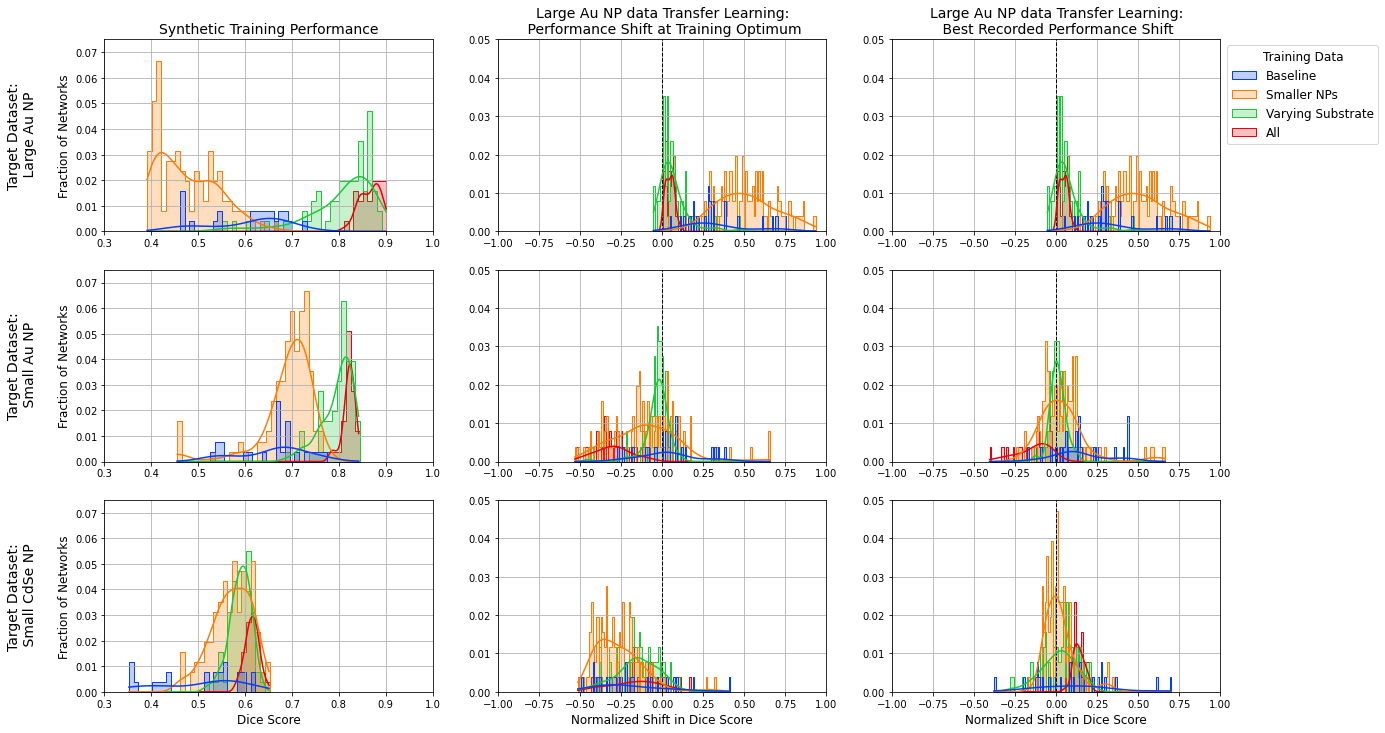

In [26]:
params = {'legend.fontsize': 12,
          'legend.title_fontsize':12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

fig, axes = plt.subplots(3,3,figsize=(20,12), facecolor="w")

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step",
              "hue_order":["baseline", "small", "substrate", "super"],
              "palette":"bright",
              }
## plot visual guidelines
for ax in axes[:,1:].ravel():
    ax.axvline(0.0, linestyle="--", color="k", linewidth=1.0)

##  plot all data
g = sns.histplot(ax=axes[0,0], data=df[df["transfer_learned"]==False], x="exp_f1-score", hue="series",**style_args)
sns.histplot(ax=axes[1,0], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", hue="series",**style_args)
sns.histplot(ax=axes[2,0], data=df[df["transfer_learned"]==False], x="exp_f1-score_CdSe", hue="series",**style_args)

sns.histplot(ax=axes[0,1], data=plot_df, x="n_val_f1_shift", hue="orig_series",**style_args)
sns.histplot(ax=axes[1,1], data=plot_df, x="n_Kath_f1_shift_at_val_peak", hue="orig_series",**style_args)
sns.histplot(ax=axes[2,1], data=plot_df, x="n_CdSe_f1_shift_at_val_peak", hue="orig_series",**style_args)

sns.histplot(ax=axes[0,2], data=plot_df, x="n_val_f1_shift", hue="orig_series",**style_args)
sns.histplot(ax=axes[1,2], data=plot_df, x="n_best_Kath_f1_shift", hue="orig_series",**style_args)
sns.histplot(ax=axes[2,2], data=plot_df, x="n_best_CdSe_f1_shift", hue="orig_series",**style_args)


## fix axis limits

for ax in axes.ravel():
    ax.set_ylim([0.0, 0.075])
    ax.grid()

for ax in axes[:,0]:
    ax.set_xlim([0.3, 1.0])
    ax.set_ylabel("Fraction of Networks", fontsize=12)

for ax in axes[:,1:].ravel():
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 0.05])
    ax.set_ylabel("")

for ax in axes[:-1, :].ravel():
    ax.set_xlabel("")

axes[2,0].set_xlabel("Dice Score", fontsize=12)
axes[2,1].set_xlabel("Normalized Shift in Dice Score", fontsize=12)
axes[2,2].set_xlabel("Normalized Shift in Dice Score", fontsize=12)
    
## fix legends
g.legend_.set_bbox_to_anchor([1.5, 1,0,0], transform = axes[0,2].transAxes)
g.legend_.set_title("Training Data")
new_labels = ['Baseline', 'Smaller NPs', 'Varying Substrate',  'All']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l,)

for axe in [axes[0,1:], axes[1,:], axes[2,:]]:
    for ax in axe:
        ax.legend().set_visible(False)

################################
axes[0,0].text(-0.25, 0.5, "Target Dataset:\n Large Au NP", fontsize=14, rotation=90, transform=axes[0,0].transAxes, ha="center", va="center")
axes[1,0].text(-0.25, 0.5, "Target Dataset:\n Small Au NP", fontsize=14, rotation=90, transform=axes[1,0].transAxes, ha="center", va="center")
axes[2,0].text(-0.25, 0.5, "Target Dataset:\n Small CdSe NP", fontsize=14, rotation=90, transform=axes[2,0].transAxes, ha="center", va="center")

# axes[0,0].text(0.5, 1.25, "Synthetic Training Performance", fontsize=14, rotation=0, transform=axes[0,0].transAxes, ha="center", va="center")
# axes[0,1].text(0.5, 1.25, "Large Au NP data Transfer Learning:\n Performance at Training Optimum", fontsize=14, rotation=0, transform=axes[0,1].transAxes, ha="center", va="center")
# axes[0,2].text(0.5, 1.25, "Large Au NP data Transfer Learning:\n Best Recorded Performance throughout Transfer Learning", fontsize=14, rotation=0, transform=axes[0,2].transAxes, ha="center", va="center")
axes[0,0].set_title("Synthetic Training Performance", fontsize=14)
axes[0,1].set_title("Large Au NP data Transfer Learning:\n Performance Shift at Training Optimum", fontsize=14)
axes[0,2].set_title("Large Au NP data Transfer Learning:\n Best Recorded Performance Shift", fontsize=14)

plt.savefig("mm_2022_fig1_normed_v1.png", dpi=300, bbox_inches="tight")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


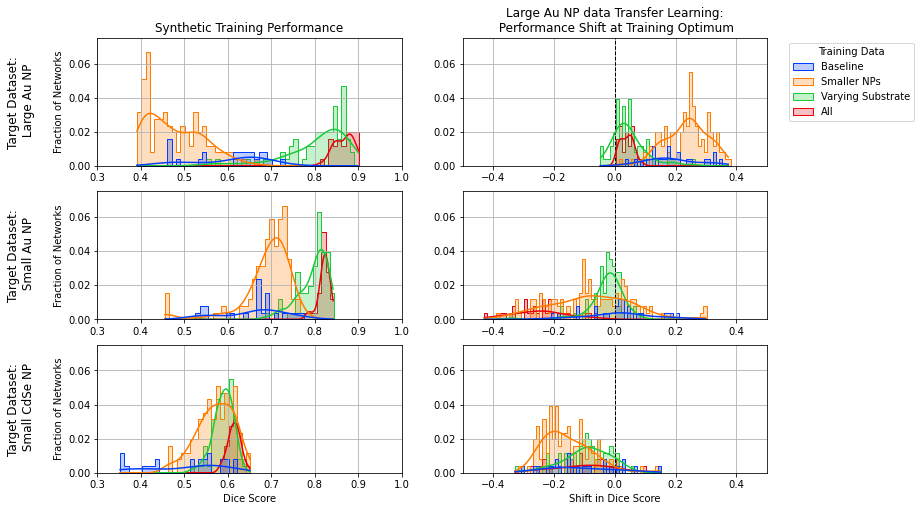

In [40]:
params = {'legend.fontsize': 10,
          'legend.title_fontsize':10,
          'legend.handlelength': 2}
plt.rcParams.update(params)

fig, axes = plt.subplots(3,2,figsize=(12,8), facecolor="w")

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step",
              "hue_order":["baseline", "small", "substrate", "super"],
              "palette":"bright",
              }
## plot visual guidelines
for ax in axes[:,1:].ravel():
    ax.axvline(0.0, linestyle="--", color="k", linewidth=1.0)

##  plot all data
g = sns.histplot(ax=axes[0,0], data=df[df["transfer_learned"]==False], x="exp_f1-score", hue="series",**style_args)
sns.histplot(ax=axes[1,0], data=df[df["transfer_learned"]==False], x="exp_f1-score_katherine", hue="series",**style_args)
sns.histplot(ax=axes[2,0], data=df[df["transfer_learned"]==False], x="exp_f1-score_CdSe", hue="series",**style_args)

sns.histplot(ax=axes[0,1], data=plot_df, x="val_f1_shift", hue="orig_series",**style_args)
sns.histplot(ax=axes[1,1], data=plot_df, x="Kath_f1_shift_at_val_peak", hue="orig_series",**style_args)
sns.histplot(ax=axes[2,1], data=plot_df, x="CdSe_f1_shift_at_val_peak", hue="orig_series",**style_args)

# sns.histplot(ax=axes[0,2], data=plot_df, x="val_f1_shift", hue="orig_series",**style_args)
# sns.histplot(ax=axes[1,2], data=plot_df, x="best_Kath_f1_shift", hue="orig_series",**style_args)
# sns.histplot(ax=axes[2,2], data=plot_df, x="best_CdSe_f1_shift", hue="orig_series",**style_args)


## fix axis limits

for ax in axes.ravel():
    ax.set_ylim([0.0, 0.075])
    ax.grid()

for ax in axes[:,0]:
    ax.set_xlim([0.3, 1.0])
    ax.set_ylabel("Fraction of Networks", fontsize=10)

for ax in axes[:,1:].ravel():
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylabel("")

for ax in axes[:-1, :].ravel():
    ax.set_xlabel("")

axes[2,0].set_xlabel("Dice Score", fontsize=10)
axes[2,1].set_xlabel("Shift in Dice Score", fontsize=10)
# axes[2,2].set_xlabel("Shift in Dice Score", fontsize=12)
    
## fix legends
g.legend_.set_bbox_to_anchor([1.5, 1,0,0], transform = axes[0,1].transAxes)
g.legend_.set_title("Training Data")
new_labels = ['Baseline', 'Smaller NPs', 'Varying Substrate',  'All']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l,)

for axe in [axes[0,1:], axes[1,:], axes[2,:]]:
    for ax in axe:
        ax.legend().set_visible(False)

################################
axes[0,0].text(-0.25, 0.5, "Target Dataset:\n Large Au NP", fontsize=12, rotation=90, transform=axes[0,0].transAxes, ha="center", va="center")
axes[1,0].text(-0.25, 0.5, "Target Dataset:\n Small Au NP", fontsize=12, rotation=90, transform=axes[1,0].transAxes, ha="center", va="center")
axes[2,0].text(-0.25, 0.5, "Target Dataset:\n Small CdSe NP", fontsize=12, rotation=90, transform=axes[2,0].transAxes, ha="center", va="center")

# axes[0,0].text(0.5, 1.25, "Synthetic Training Performance", fontsize=14, rotation=0, transform=axes[0,0].transAxes, ha="center", va="center")
# axes[0,1].text(0.5, 1.25, "Large Au NP data Transfer Learning:\n Performance at Training Optimum", fontsize=14, rotation=0, transform=axes[0,1].transAxes, ha="center", va="center")
# axes[0,2].text(0.5, 1.25, "Large Au NP data Transfer Learning:\n Best Recorded Performance throughout Transfer Learning", fontsize=14, rotation=0, transform=axes[0,2].transAxes, ha="center", va="center")
axes[0,0].set_title("Synthetic Training Performance", fontsize=12)
axes[0,1].set_title("Large Au NP data Transfer Learning:\n Performance Shift at Training Optimum", fontsize=12)
# axes[0,2].set_title("Large Au NP data Transfer Learning:\n Best Recorded Performance Shift", fontsize=14)

plt.savefig("mm_2022_fig1_v2.png", dpi=300, bbox_inches="tight")